<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/DataExplorationVisuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Mounted at /content/gdrive


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls

Cloning into 'teambrainiac'...
remote: Enumerating objects: 1050, done.
remote: Counting objects: 100% (1050/1050), done.
remote: Compressing objects: 100% (804/804), done.
remote: Total 1050 (delta 661), reused 463 (delta 230), pack-reused 0
Receiving objects: 100% (1050/1050), 80.45 MiB | 30.08 MiB/s, done.
Resolving deltas: 100% (661/661), done.
/content/teambrainiac/source
access_data.py			  models
AccuracyMeasures.ipynb		  process.py
analysis.py			  SingleSubjectSVM.ipynb
cross_validation.py		  SubjectVisualization_Models_ZNORM.ipynb
data				  SVM_Group_Adolescent_Whole_brain.ipynb
DataExploration_SingleSubj.ipynb  SVM_Group_YA_Whole_brain.ipynb
DataExplorationVisuals.ipynb	  TestMask.ipynb
DL				  Timeseries_Cross_Validation.ipynb
Explore_data.ipynb		  train.py
Group_All_MASK_SVM.ipynb	  utils.py
Group_charts.ipynb		  VisualizationPlayground.ipynb
helper				  Visualize_Data.ipynb
Images				  visualize.py
__init__.py


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config.py
User uploaded file "path_config.py" with length 228 bytes


In [79]:
# Import libraries
!pip install boto3 nilearn nibabel
import nibabel as nib
from nilearn import plotting, image
from nilearn.image import threshold_img
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pickle
#from utils import data_to_nib, load_mat, open_pickle, access_load_data, save_data, create_mask, labels_mask_binary, masking_data, masked_data_n_labels
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import numpy as np
import random
from nilearn.signal import clean
#from utils import *
from access_data import *
from process import *
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [29]:
#open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
subject_ids = data_path_dict['subject_ID']

In [114]:
##load dictionary to open normalization paths for csv files and adolescent and young adult model/results
path_dict = open_pickle('/content/drive/My Drive/data/dataexploration/norm_data_paths.pkl')
##load cross validation results
#cv_results_expanded = open_pickle('/content/drive/My Drive/data/dataexploration/cv_results_ZNORM_expanded.pkl')
cv_results_expanded_ovo = open_pickle('/content/drive/My Drive/data/dataexploration/cv_results_ZNORM_expanded_ovo.pkl')
    


In [115]:
##create empty data frames for normalization results
ya_final_df = pd.DataFrame() ##young adult df
adol_final_df = pd.DataFrame() ##adol_final_df
all_final_df = pd.DataFrame() ##df for both age groups

##for loop to create data frames
##appending all normalization strategies in to one dataframe
for key in path_dict.keys():
  norm_path = path_dict[key]['csv_file']  
  if len(all_final_df)==0: ##if df is empty
    all_final_df = pd.read_csv(norm_path)
    all_final_df['NormType'] = key
    adol_final_df = all_final_df.iloc[0:33,]
    ya_final_df = all_final_df.iloc[33:,:]
  else:
    norm_df = pd.read_csv(norm_path)
    norm_df['NormType'] = key
    adol_df = norm_df.iloc[0:33,:]
    ya_df = norm_df.iloc[33:,:]
    all_final_df = pd.concat([all_final_df,norm_df])
    adol_final_df = pd.concat([adol_final_df,adol_df])
    ya_final_df = pd.concat([ya_final_df,ya_df])

In [116]:
##create summary statistics for the three df (all,adolescent,young adult)
##all 52 subjects
stats_norm_all = all_final_df.groupby(['NormType']).mean()
stats_norm_all.reset_index(inplace=True) #reset index
stats_norm_all.to_csv('/content/drive/My Drive/data/dataexploration/all_final_summary_normalizations.csv') ##save to csv
print('Summary Statistics for All 52 subjects')
print(stats_norm_all.head())
print("")
##adolescent
stats_norm_adol = adol_final_df.groupby(['NormType']).mean()
stats_norm_adol.reset_index(inplace=True) #reset index
stats_norm_adol.to_csv('/content/drive/My Drive/data/dataexploration/adol_final_summary_normalizations.csv') ##save to csv
print('Summary Statistics for 32 adolescent subjects')
print(stats_norm_adol.head())
print("")
##young adult
stats_norm_ya = ya_final_df.groupby(['NormType']).mean()
stats_norm_ya.reset_index(inplace=True) #reset index
stats_norm_ya.to_csv('/content/drive/My Drive/data/dataexploration/ya_final_summary_normalizations.csv') ##save to csv
print('Summary Statistics for 19 young adult subjects')
print(stats_norm_ya.head())
print("")

Summary Statistics for All 52 subjects
  NormType  Unnamed: 0  TrainAcc    ValAcc  ValPrecision  ValRecall     ValF1  \
0   NONORM        25.5  0.745192  0.560440      0.450920   0.474359  0.387308   
1      PSC        25.5  0.814103  0.562729      0.536591   0.580128  0.496667   
2    ZNORM        25.5  0.995192  0.739469      0.756749   0.713828  0.730802   

    TestAcc  TestPrecision  TestRecall    TestF1  
0  0.522665       0.345432    0.367674  0.284241  
1  0.543727       0.543426    0.628205  0.505227  
2  0.658883       0.666990    0.633242  0.646274  

Summary Statistics for 32 adolescent subjects
  NormType  Unnamed: 0  TrainAcc    ValAcc  ValPrecision  ValRecall     ValF1  \
0   NONORM        16.0  0.740620  0.537157      0.426671   0.453102  0.357706   
1      PSC        16.0  0.802309  0.552309      0.544547   0.604618  0.510268   
2    ZNORM        16.0  0.995310  0.719697      0.732896   0.704906  0.714844   

    TestAcc  TestPrecision  TestRecall    TestF1  
0  0.5151

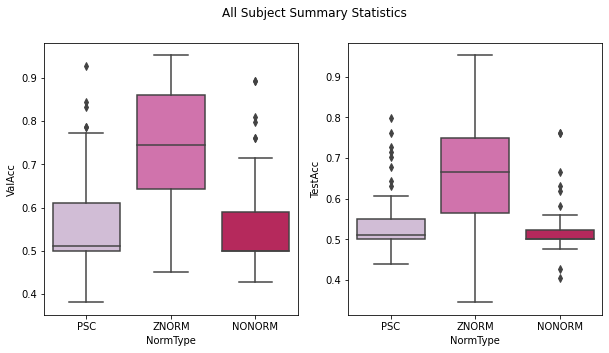

In [117]:
##create box plots accross all subjects
column_names = ['ValAcc','TestAcc'] #grab columns I want to plot
fig,axes=plt.subplots(1,2,figsize=(10,5)) #get figure size
sns.boxplot(x='NormType',y='ValAcc',data=all_final_df, ax=axes[0],palette='PuRd') #plot val scroes
sns.boxplot(x='NormType',y='TestAcc',data=all_final_df, ax=axes[1],palette='PuRd')  #plot test scores
fig.suptitle('All Subject Summary Statistics')
plt.show()
fig.savefig('/content/drive/My Drive/data/dataexploration/all_subject_norm.png')

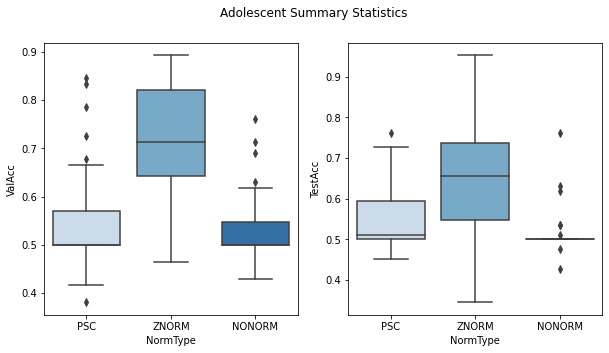

In [118]:
##create box plots for adolescent
column_names = ['ValAcc','TestAcc'] #grab columns I want to plot
fig,axes=plt.subplots(1,2,figsize=(10,5)) #get figure size
sns.boxplot(x='NormType',y='ValAcc',data=adol_final_df, ax=axes[0],palette='Blues') #plot val scroes
sns.boxplot(x='NormType',y='TestAcc',data=adol_final_df, ax=axes[1],palette='Blues')  #plot test scores
fig.suptitle('Adolescent Summary Statistics')
plt.show()
fig.savefig('/content/drive/My Drive/data/dataexploration/adolescent_norm.png')

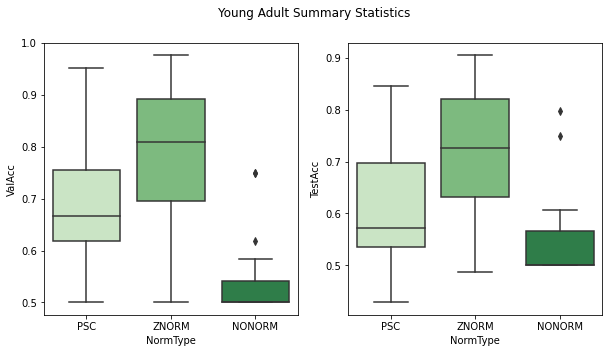

In [123]:
##create box plots for ya
column_names = ['ValAcc','TestAcc'] #grab columns I want to plot
fig,axes=plt.subplots(1,2,figsize=(10,5)) #get figure size
sns.boxplot(x='NormType',y='ValAcc',data=ya_final_df, ax=axes[0],palette='Greens') #plot val scroes
sns.boxplot(x='NormType',y='TestAcc',data=ya_final_df, ax=axes[1],palette='Greens') #plot test scores
fig.suptitle('Young Adult Summary Statistics')
plt.show()
fig.savefig('/content/drive/My Drive/data/dataexploration/ya_norm.png')

In [51]:
#create for loop to create summary df of cross validation results using decision function ovr
final_df = pd.DataFrame()
for sub_id in subject_ids:
  model = cv_results_expanded[sub_id]['model'] #load model from dictionary
  model.cv_results_ #get cv_results
  model_df = pd.DataFrame(model.cv_results_) #convert to dataframe
  model_df['subject'] = sub_id #add subject id column
  sub_df = model_df[['subject','param_C','param_kernel','mean_test_score','std_test_score']] #grab columns of interest
  #create df
  if len(final_df)==0:
    final_df = sub_df
  else:
    final_df = pd.concat([final_df,sub_df])


In [65]:
##create summary statistics for decision function ovr
stats_df = final_df.groupby(['param_C','param_kernel']).agg({'mean_test_score': ['mean','std']})
##add column to condense param_c and param_kernel for plotting purposes
final_df['Cross Validation Parameters'] = "Kernel: " + final_df['param_kernel'] + " C: " + final_df['param_C'].astype(str)
#create a sub_df for graph
cv_results_graph_df = final_df[['subject','Cross Validation Parameters','mean_test_score',]]
#create a df to export for summary statistics in excel
final_df_test = pd.pivot_table(cv_results_graph_df,index = ['subject'],columns=['Cross Validation Parameters'],values=['mean_test_score'])
final_df_test.to_csv('/content/drive/My Drive/data/dataexploration/cv_results_table_ovr.csv')

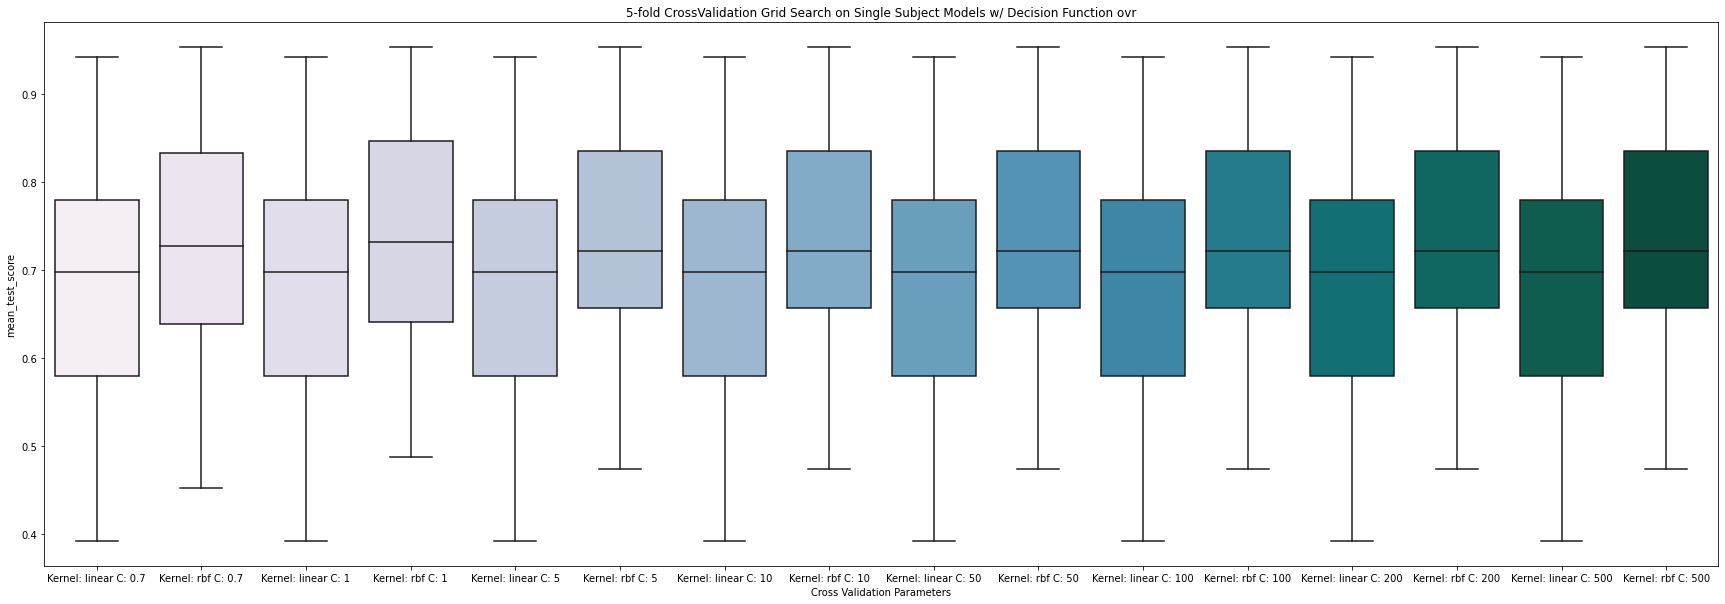

<Figure size 432x288 with 0 Axes>

In [66]:
##plot cross validation results for decision function ovr
plt.figure(figsize=(30,10))
plt.title('5-fold CrossValidation Grid Search on Single Subject Models w/ Decision Function ovr')
sns.boxplot(x='Cross Validation Parameters',y='mean_test_score',data=cv_results_graph_df,palette="PuBuGn")
plt.show()
plt.savefig('/content/drive/My Drive/data/dataexploration/cv_results_expanded_ovr.png')

In [14]:
#get image for header information
affine_image = access_load_data('w3rtprun_01.nii',False)
#get t1_image image for background
#this image is a template of a warped brain to normalized space
t1_image = access_load_data('single_subj_T1_resampled.nii',False)
## this is the mni image
mni_image = access_load_data('MNI152.nii',False)

In [30]:
def get_mask(mask_type,data_path_dict,mask_ind):
  """
    Function to return the indices of mask of what brain voxels we want to include in analysis
    Params:
      data_path_dict  : dictionary containing paths to all data stored on AWS
      mask_type: name of mask we want to use
      mask_ind: index of where the path to the masks are 0: full brain mask plus masks that subtract region
              1: Regions of interest(ROIs) mask out full brain except structure we care about
  """
  mask_data_filepath = data_path_dict['mask_data'][mask_ind] #path to masked data     
  mask_type_dict = access_load_data(mask_data_filepath, True) #get the mask data dictionary
  np_array_mask = mask_type_dict[mask_type] #get the mask array
  mask = np.ma.make_mask(np_array_mask).reshape(79*95*79,order='F') #create a 1-D array for the mask. Important to use Fourier Transformation as we are working in brain space!
  ind = np.where(mask==True)
  return ind

In [22]:
def create_bmaps(sub_id,data,indices_mask,image):
  """
    Function to compute beta maps using Lagrange values(alphas) from SVM.
      1. We want to create a zeroed vector to fill with the clf.dual_coef which correspond to the alphas
      2. We fill the vector with the alphas corresponding to the indices of the support vectors in clf.support_
      3. Reshape so we can find dot product
      4. Find dot prodoct between alphas and X_train data
      5. create a empty brain with dimensions 79*95*79
      6. reshape to a flattened vector
      7. fill the indices of the not masked voxels with the dot product
      8. reshape back to 3d brain
      9. create a nifti file of the brain for imaging
    Params:
      sub_id: subject id to get data from
      data: subject model and training/test data
      ind: indices of voxels to mask out
      image: template image to get header information for brain image
    Returns:
      bmap3: nifti file for imaging
  """
 
  clf = data[sub_id]['model'] # grab model
  X_train = data[sub_id]['X_train'] #grab training data
  y_train = data[sub_id]['y_train'] #grab labels

  alphas = np.zeros((84)) #create zero array
  alphas[clf.support_] = clf.dual_coef_ #fill indices with corresponding alphas
  alphas = alphas.reshape(1,-1) #reshape
  bmap = np.dot(alphas,X_train) #find dot product of X_train and alphas
  bmap2 = np.zeros((79,95,79)) #create empty 3-d brain
  bmap2 = bmap2.reshape(79*95*79) #flatten it to 1-d array
  bmap2[indices_mask] = bmap #fill indices of unmasked voxels w/the values created in bmap
  bmap2_3d = bmap2.reshape(79,95,79,order='F') #reshape back to a brain (3-d)
  bmap3 = nib.Nifti1Image(bmap2_3d,affine=image.affine,header=image.header) #save as nifti
  return bmap2,bmap3
  

In [130]:
def plot_map(bmap3,norm_type,subject_type,outfname=None,threshold=.0001):
  """
    Function to plot beta map images from SVM models will either display image or save it to destination
    Params:
      bmap3: Nifti: image to plot
      norm_type: str: normalization strategy
      subject_type: str: young adult or adolescent
      outfname: str: if set to none will display image, other wise will save image to indicated outfname
      threshold: str or float: threshold for images, if voxel is less than threshold, it will not be shown
                               if want to see whole-voxel activation set to very low number as above
                               Nilearn plot_img documentation: https://nilearn.github.io/modules/generated/nilearn.plotting.plot_img.html
  """
  disp_image = None ##set image to nothing
  disp_image = bmap3 ##set image to bmap3
  title_str = f'{norm_type} for {subject_type}' ##format string for title of image
  
  if outfname!=None: #if outfname specified
    output_file_name = f'{outfname}{norm_type}_{subject_type}.png'
    disply = plotting.plot_img(disp_image, bg_img = mni_image, display_mode='z', cut_coords=(-35,-20,0,20,35,50,65,70), threshold=threshold,
                          output_file=output_file_name, colorbar=True,cmap='cold_white_hot',black_bg=False)
  else:
    display = plotting.plot_img(disp_image, bg_img = mni_image, display_mode='z', cut_coords=(-35,-20,0,20,35,50,65,70),threshold=threshold,
                           colorbar=True,cmap='cold_white_hot',black_bg=False)
    display.title(title_str, x=0.01, y=0.99, size=15, color='w', bgcolor='black')
    

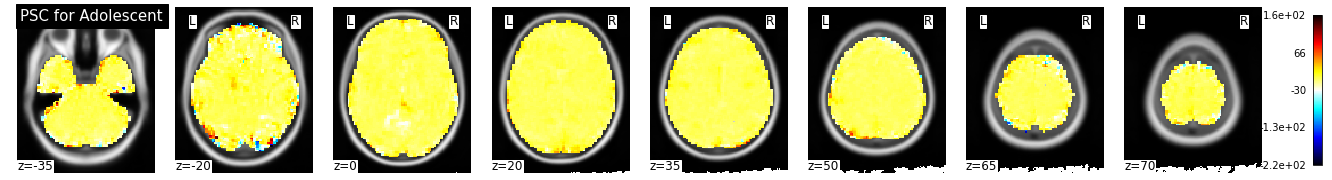

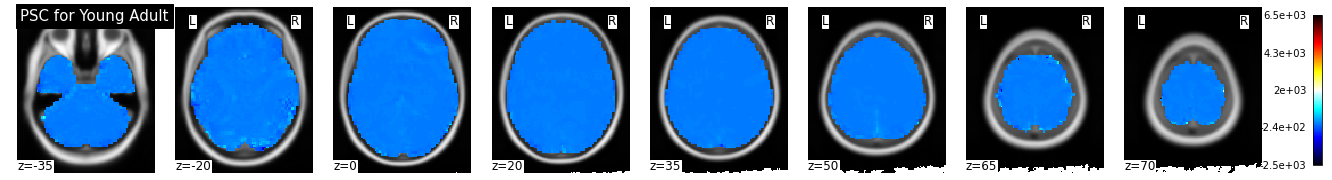

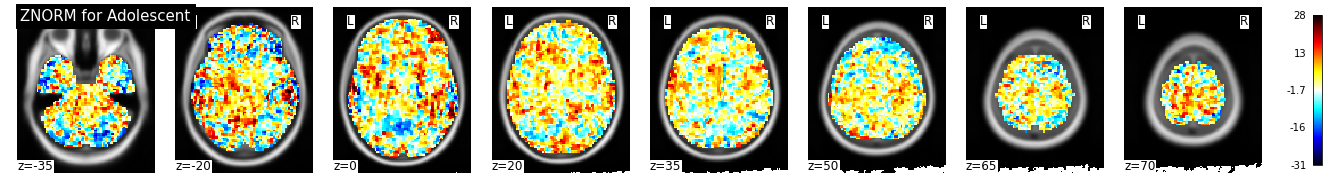

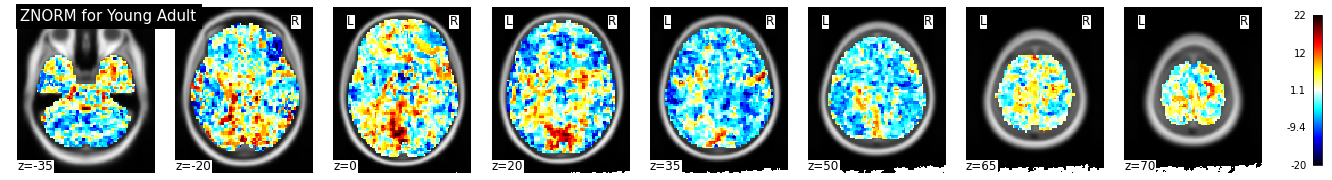

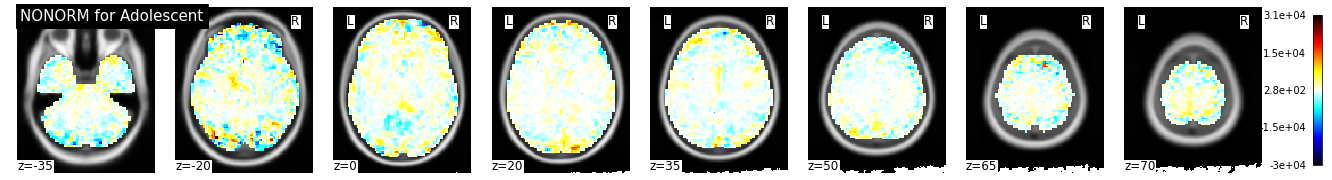

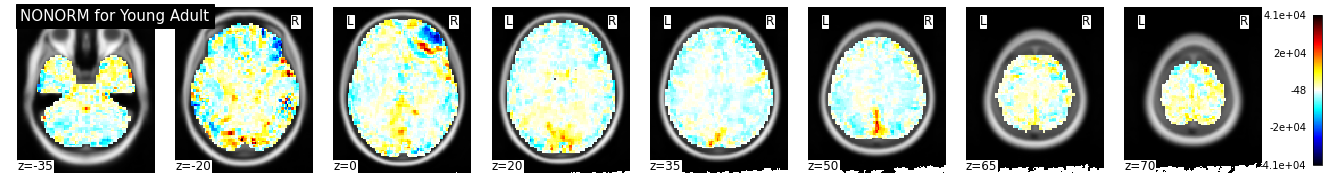

In [131]:
subject_types = ['Adolescent','Young Adult'] ##which group it belongs too
ind = get_mask('mask',data_path_dict,0) #grab indices of mask to use
bmap2_dict = {} #dictionary to save bmap2
for norm_type in path_dict.keys(): #iterate over norm types
  pick_files = path_dict[norm_type]['sub_pickles'] #get pickle file paths for two example subjects
  sub_ids = path_dict[norm_type]['sub_id'] #get subject ids
  bmap2_dict[norm_type] = {} #create empty dict by norm type in bmap2_dict
  for sidx in range(len(pick_files)): #iterate over pickle files
    bmap3=None #set bmap3 to none (nilearn is fickle)
    disp_image=None #set disp image to none (nilearn is fickle)
    model_dict = access_load_data(pick_files[sidx],False) #get subject model dictionary
    bmap2,bmap3 = create_bmaps(sub_ids[sidx],model_dict,ind,affine_image) #grab bmap2(array) and bmap3 (nifti)
    bmap2_dict[norm_type][sub_ids[sidx]] = bmap2 #store bmap two in dictionary
    plot_map(bmap3,norm_type,subject_types[sidx],outfname=None,threshold=.0001) #get image

/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:2830: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


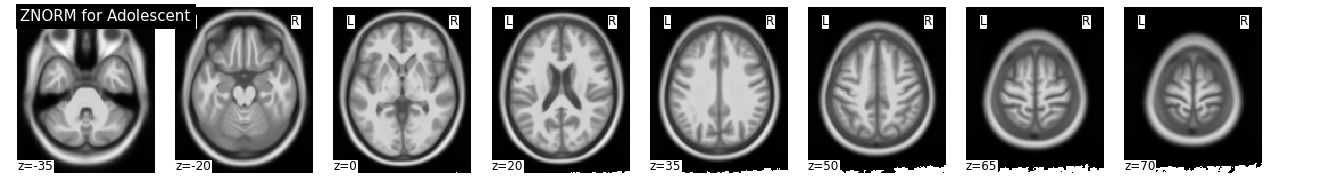

In [91]:
bmap_test = bmap2_dict['ZNORM']['10047_09030']
ind = get_mask('nacc_aal',data_path_dict,1)
bmap2 = np.zeros((79,95,79)) #create empty 3-d brain
bmap2 = bmap2.reshape(79*95*79) #flatten it to 1-d array
bmap2[ind] = bmap_test[ind] #fill indices of unmasked voxels w/the values created in bmap
bmap2_3d = bmap2.reshape(79,95,79,order='F') #reshape back to a brain (3-d)
bmap3 = nib.Nifti1Image(bmap2_3d,affine=affine_image.affine,header=affine_image.header) #save as nifti
plot_map(bmap3,'ZNORM',subject_types[0],outfname=None,threshold=.0001)

In [140]:
def get_decision_function(sub_id,data):
  clf = data[sub_id]['model']
  X_val = data[sub_id]['X_val']
  X_test = data[sub_id]['X_test']
  labels = data[sub_id]['y_train']

  x_val_decision_func = clf.decision_function(X_val)
  x_test_decision_func = clf.decision_function(X_test)
  #alphas = alphas.reshape(1,-1)
  return x_val_decision_func,x_test_decision_func,labels

In [141]:
def plot_decision_scores(scores,labels,norm_type,subject_type,score_type):
  fig, ax = plt.subplots(1,1,figsize=(15, 5))
  ax.plot(scores, lw=3, label='Predicted tc')
  ax.plot(labels, lw=3, label='predictor tc')
  #ax.set_xlim(0, acq_num-1)
  ax.set_xlabel('time [volumes]', fontsize=20)
  ax.tick_params(labelsize=12)
  ax.set_title(f'{subject_type} Decision Function Scores for {norm_type} on {score_type} set')
  ax.legend()
  plt.show()

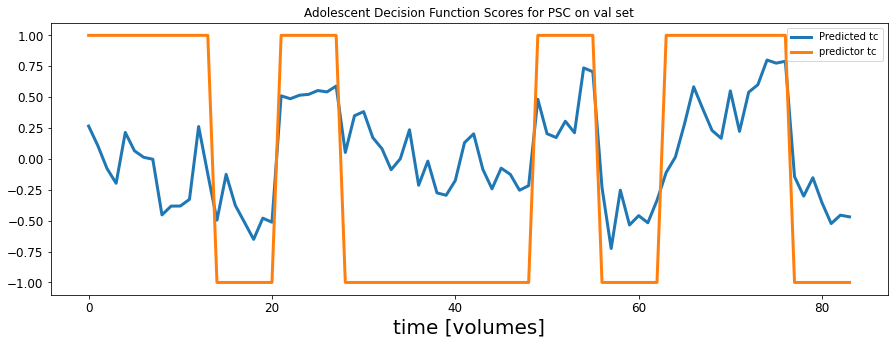

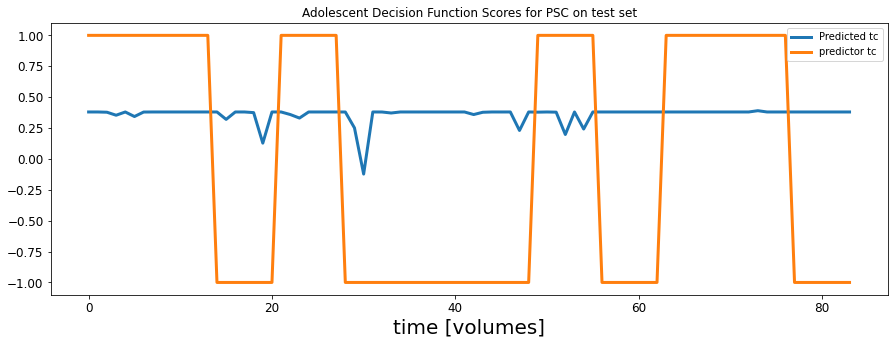

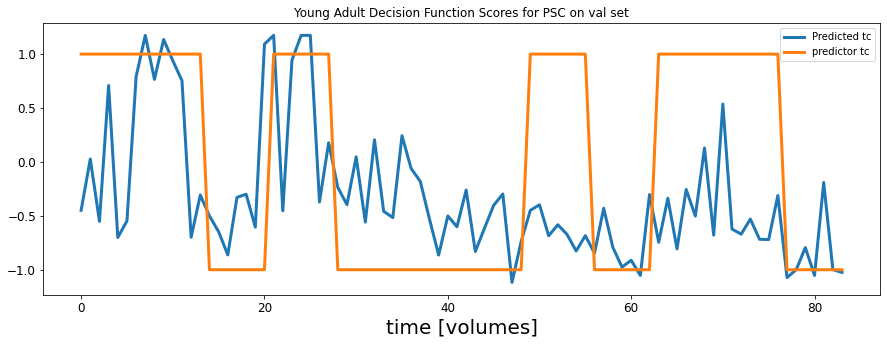

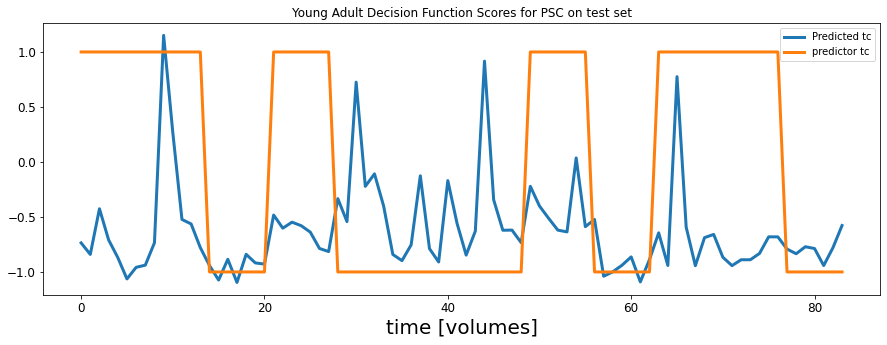

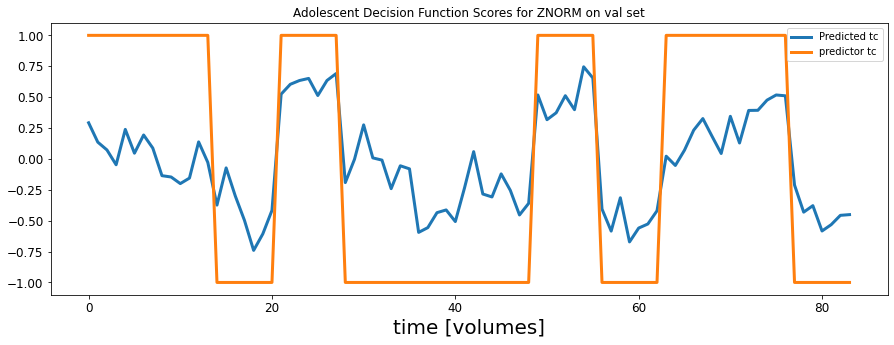

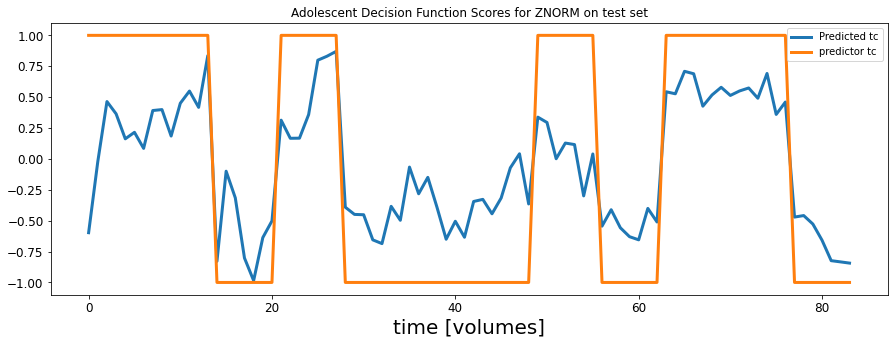

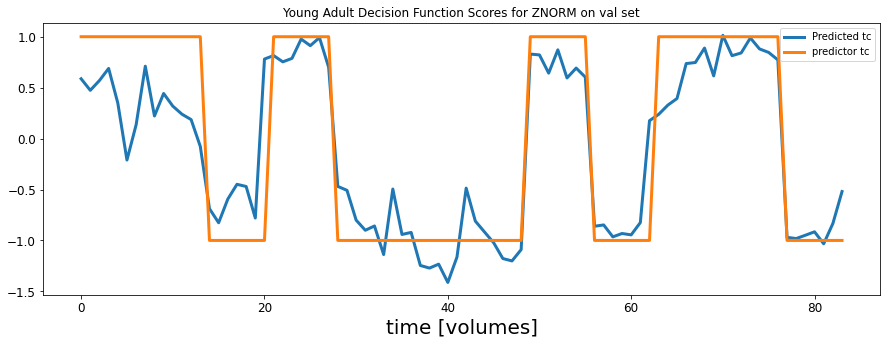

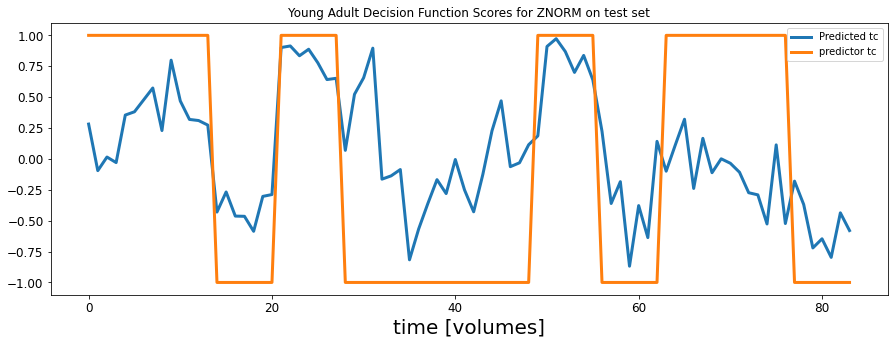

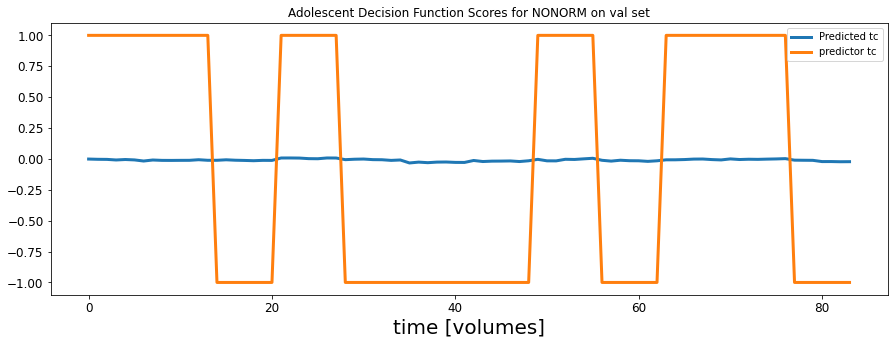

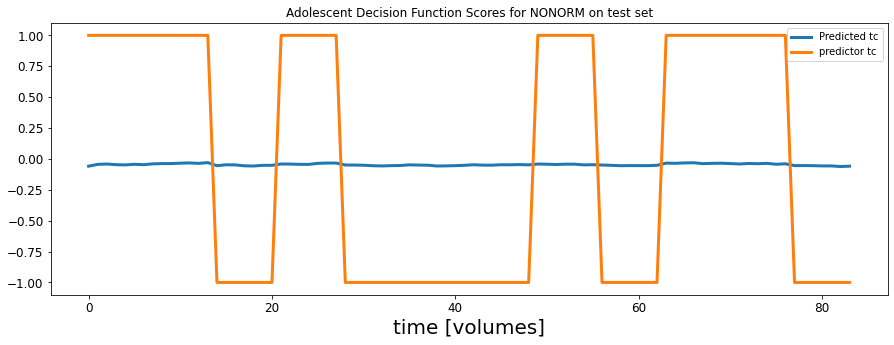

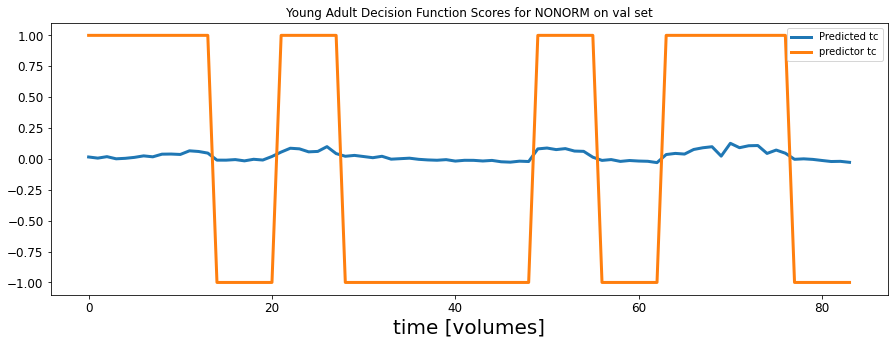

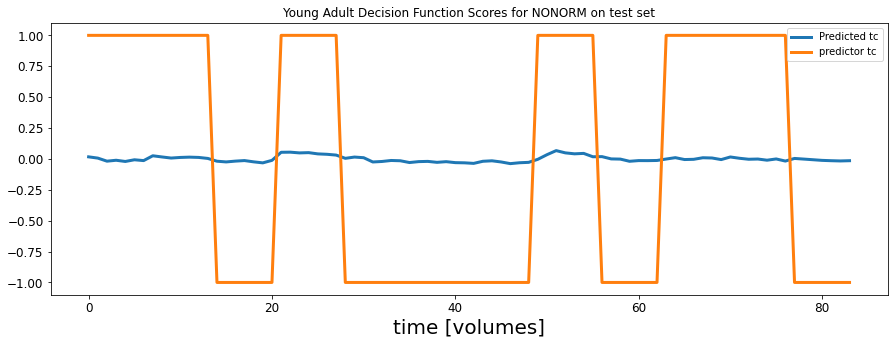

In [142]:
subject_types = ['Adolescent','Young Adult'] ##which group it belongs too
for norm_type in path_dict.keys(): #iterate over norm types
  pick_files = path_dict[norm_type]['sub_pickles'] #get pickle file paths for two example subjects
  sub_ids = path_dict[norm_type]['sub_id'] #get subject ids
  for sidx in range(len(pick_files)): #iterate over pickle files
    model_dict = access_load_data(pick_files[sidx],False) #get subject model dictionary
    x_val_decision_func,x_test_decision_func,labels = get_decision_function(sub_ids[sidx],model_dict)
    decision_function_labels = np.where(labels==0,-1,1)
    plot_decision_scores(x_val_decision_func,decision_function_labels,norm_type,subject_types[sidx],'val')
    plot_decision_scores(x_test_decision_func,decision_function_labels,norm_type,subject_types[sidx],'test')

In [137]:
model_dict

{'10047_09030': {'X_test': array([[12.4609585 ,  7.268238  ,  5.043283  , ...,  5.484235  ,
           5.487503  ,  4.506818  ],
         [-0.47776568,  1.7869513 ,  1.6526089 , ...,  0.6514874 ,
           0.65397567,  0.5386068 ],
         [-6.9603763 , -1.7093297 , -1.347871  , ...,  2.5211923 ,
           2.5223694 ,  2.7038398 ],
         ...,
         [12.104015  ,  9.591857  ,  7.0086875 , ...,  2.8936718 ,
           2.9078565 ,  2.5178761 ],
         [15.73339   ,  9.747236  ,  6.641967  , ...,  3.8430412 ,
           3.8567793 ,  3.1911902 ],
         [10.002695  ,  8.441953  ,  6.1126604 , ...,  5.8928022 ,
           5.909067  ,  5.1906543 ]], dtype=float32),
  'X_train': array([[-4.2216444 , -1.774729  , -1.1855764 , ...,  4.0535116 ,
           4.072721  ,  3.3134587 ],
         [-3.0687623 , -1.5784403 , -0.74209195, ...,  1.3951768 ,
           1.4015613 ,  1.0329509 ],
         [ 2.9965699 ,  1.428417  ,  1.8344587 , ...,  0.8695348 ,
           0.8645591 ,  0.32924995


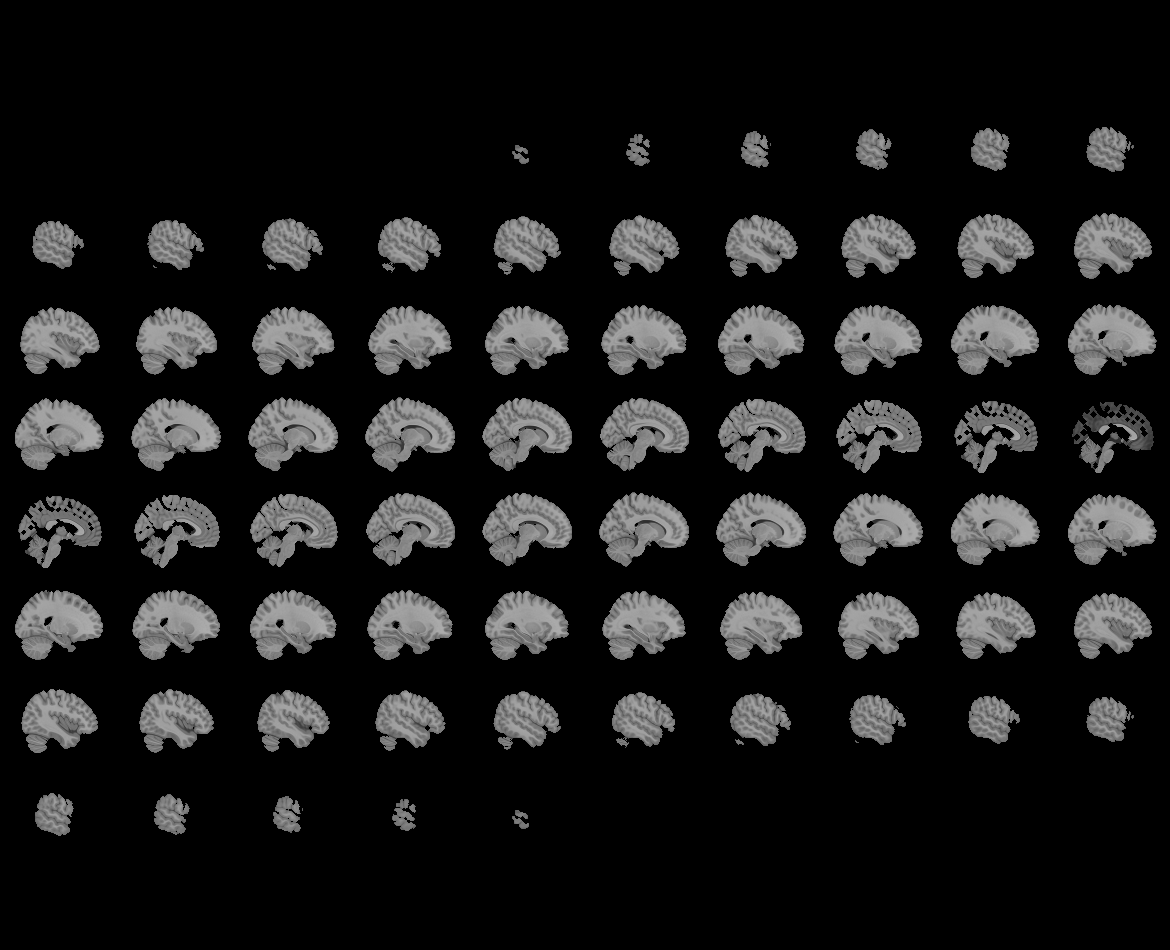
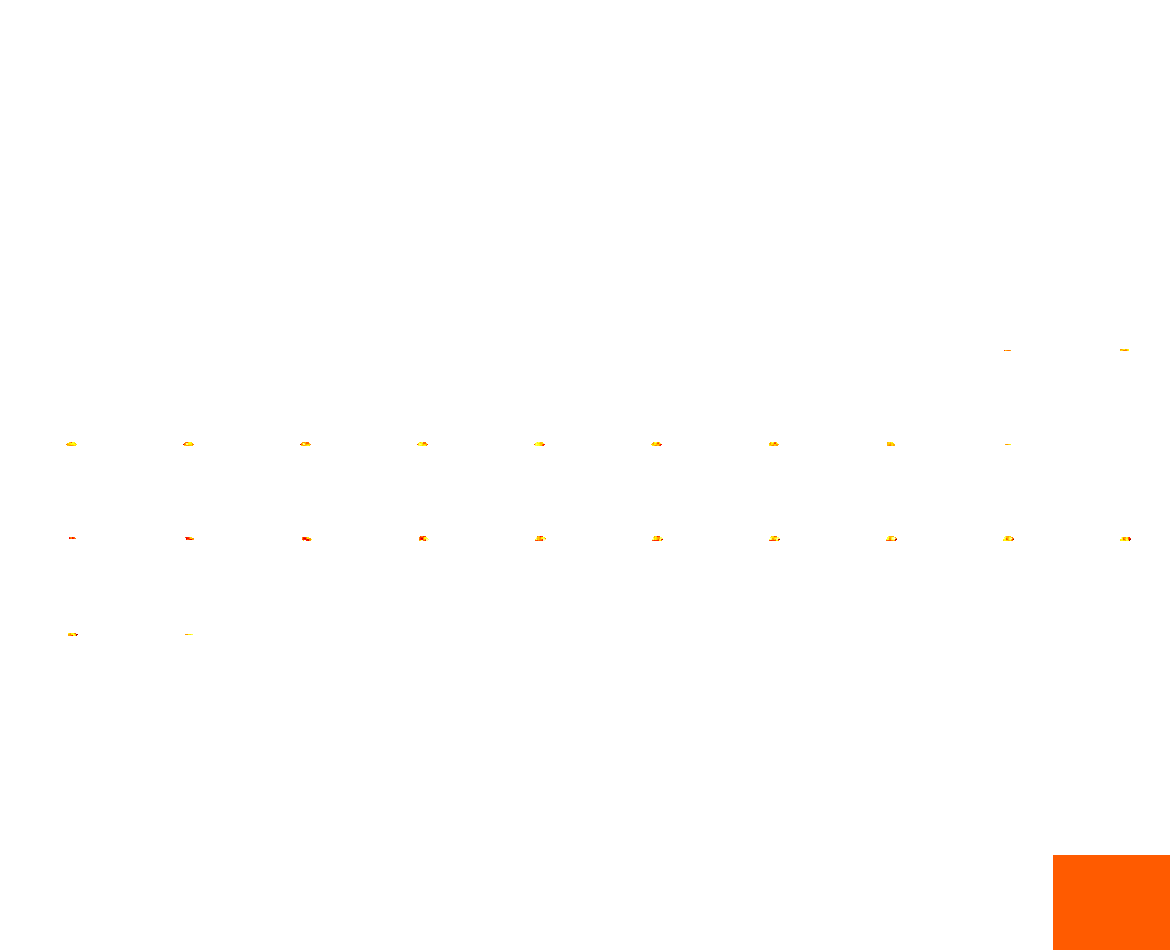

In [96]:
###just for fun

from nilearn import plotting, datasets  
# #for sub_id in subject_ids:
#   path,file_beginning = ("/content/drive/My Drive/data/model_one_run_zcoreonly/",'sub_id_one_run_model_znorm')
#   destination_path = f"{path}{file_beginning}{sub_id}.pkl"
#   model_dict = open_pickle(destination_path)
#   bmap3 = create_bmaps(sub_id,model_dict,indices_mask,affine_image)  
#>>> img = datasets.fetch_localizer_button_task()['tmap']     
html_view = plotting.view_img(bmap3, bg=mni_image, cmap = 'cold_white_hot', cut_coords=[1, 55, -3],
                                    title="Motor contrast")
html_view  

In [97]:
subject_types = ['Adolescent','Young Adult']
ind = get_mask('mask',data_path_dict,0)

##adolesent
pick_files = path_dict['ZNORM']['sub_pickles']
sub_ids = path_dict['ZNORM']['sub_id']
  
bmap3=None
disp_image=None
model_dict = access_load_data(pick_files[0],False)
bmap3 = create_bmaps(sub_ids[0],model_dict,ind,affine_image)
html_view = plotting.view_img(bmap3, bg=mni_image, threshold='98%', cmap = 'cold_white_hot', cut_coords=[1, 55, -3],
                                    title="ZNORM Adolescent")
html_view

TypeError: ignored


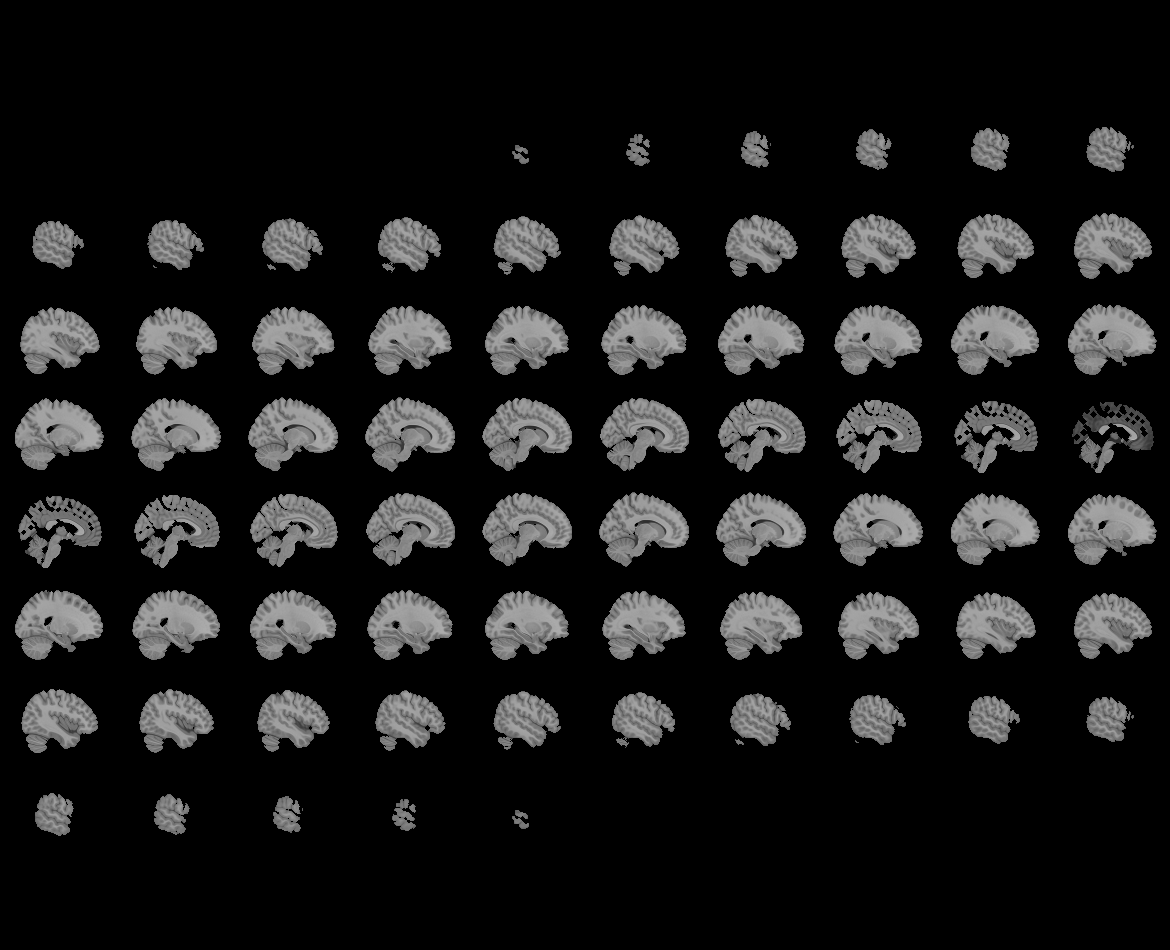
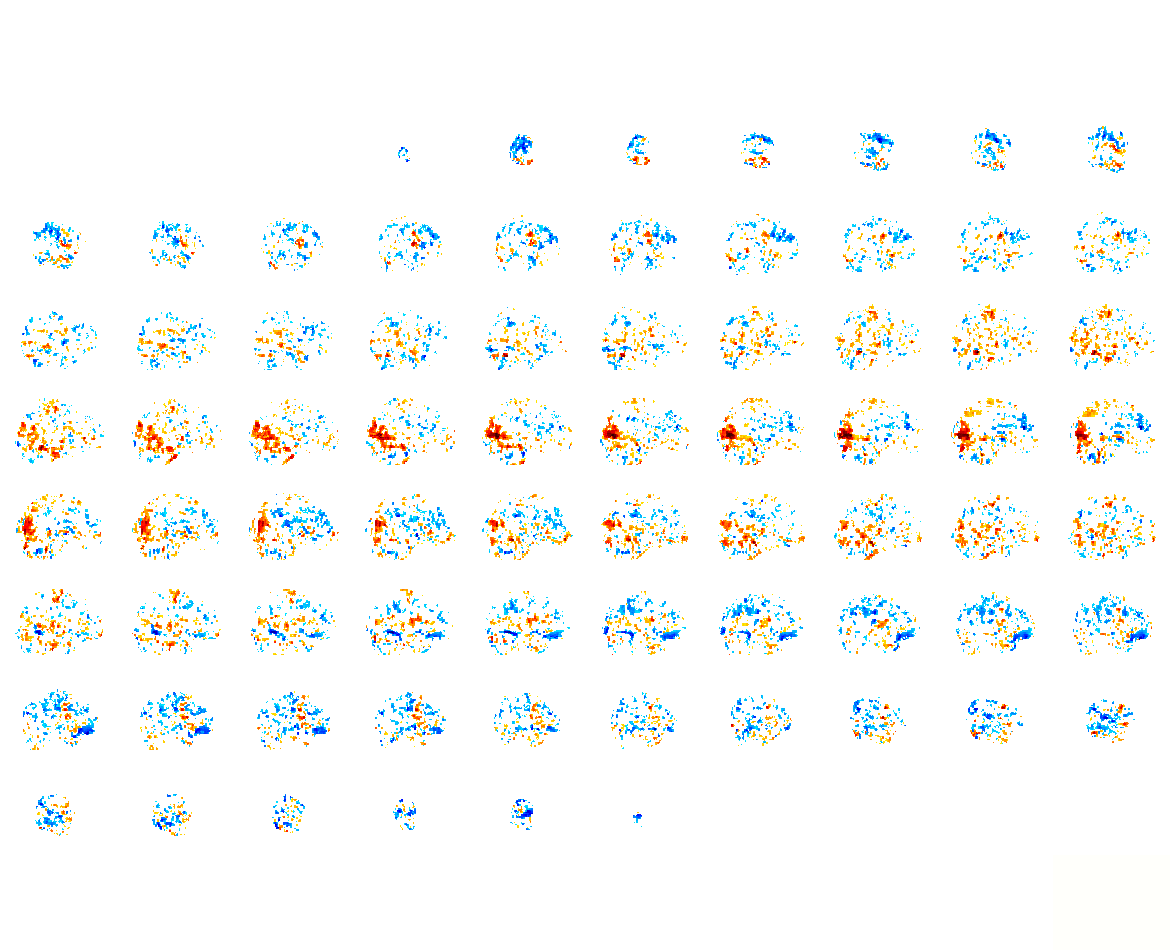

In [ ]:
subject_types = ['Adolescent','Young Adult']
ind = get_mask('mask',data_path_dict,0)

##young adult
pick_files = path_dict['ZNORM']['sub_pickles']
sub_ids = path_dict['ZNORM']['sub_id']
  
bmap3=None
disp_image=None
model_dict = access_load_data(pick_files[1],False)
bmap3 = create_bmaps(sub_ids[1],model_dict,ind,affine_image)
html_view = plotting.view_img(bmap3, bg=mni_image, threshold='90%', cmap = 'cold_white_hot', cut_coords=[1, 55, -3],
                                    title="ZNORM Young Adult")
html_view


In [ ]:
Z.shape

(30, 30)